# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.436905,False,1.746834
1,0.276758,True,6.017127
2,-0.035913,False,0.990615
3,0.109910,False,1.095498
4,-1.136348,False,-0.984085
...,...,...,...
995,-0.623168,False,-1.233430
996,0.748328,True,5.313026
997,-0.194007,True,4.264915
998,-0.555842,False,1.552783


<AxesSubplot: xlabel='v0'>

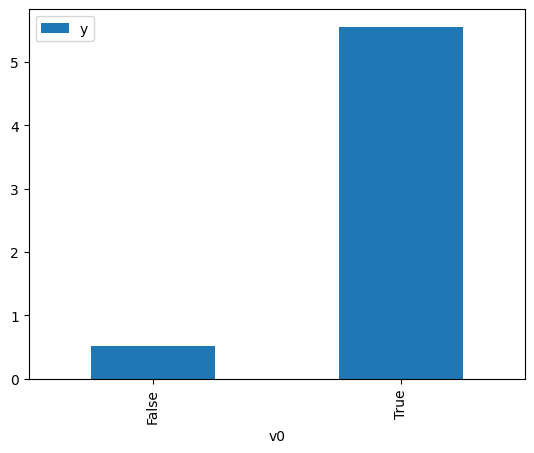

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

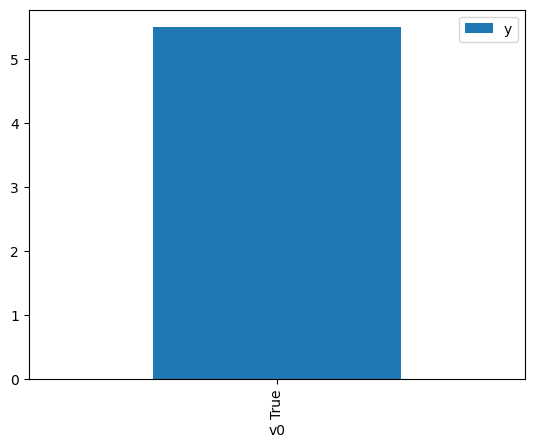

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.451867,False,-5.228110,0.972026,1.028779
1,0.367597,False,0.576006,0.373936,2.674253
2,0.491363,False,2.175727,0.333202,3.001187
3,0.711783,False,0.566149,0.266703,3.749491
4,-1.658345,False,-3.368804,0.917168,1.090313
...,...,...,...,...,...
995,0.991758,False,2.705305,0.195459,5.116168
996,-1.007565,False,-0.140347,0.812533,1.230720
997,0.107398,False,0.149837,0.464967,2.150689
998,0.221108,False,-0.007530,0.424521,2.355598


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.006548,True,6.710813,0.494035,2.024147
1,-0.741454,True,3.937414,0.252934,3.953604
2,-0.498823,True,4.745848,0.324462,3.082022
3,0.218096,True,3.273484,0.574418,1.740891
4,0.651958,True,6.479414,0.716099,1.396454
...,...,...,...,...,...
995,-0.498823,True,4.745848,0.324462,3.082022
996,0.628752,True,6.779816,0.709251,1.409938
997,-0.394105,True,4.843123,0.358377,2.790360
998,0.628752,True,6.779816,0.709251,1.409938


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.201e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                        0.00
Time:                        06:38:19   Log-Likelihood:                         -1360.8
No. Observations:                1000   AIC:                                      2726.
Df Residuals:                     998   BIC:                                      2735.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1106      0.036     31.135      0.000       1.041       1.181
x2             5.1407      0.047    109.376      0.000       5.048       5.233
==============================================================================
Omnibus:                        0.779   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.700
Skew:                          -0.062   Prob(JB):                        0.705
Kurtosis:                       3.040   Cond. No.                         1.99
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""